In [38]:
import os
import sys
import ccdproc
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/home/idies/workspace/Storage/svhuezo21/persistent/hrpo-pipeline')
import fpnfix
import aperturePhot as ap


from astropy import units as u
from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std
from ccdproc import ImageFileCollection
from aperturePhot import showimage as show_image 
from pathlib import Path



In [28]:
data_dir_base = '/home/idies/workspace'
data_dir = 'Storage/svhuezo21/persistent/hrpo-pipeline'
data_dir = os.path.join(data_dir_base, data_dir)

#Make a directory to store reduced images
reduced_data = Path(data_dir, 'reduced_images')
reduced_data.mkdir(exist_ok=True)

In [29]:
#Load all of the datafiles
files = ccdp.ImageFileCollection(data_dir)

In [30]:
#Print out summary of data file with selected headers 
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

TypeError: 'NoneType' object is not subscriptable

In [31]:
#Select the calibrated bias images and combine them
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu')

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(reduced_data / 'combined_bias.fit'), overwrite=True)

TypeError: 'NoneType' object is not subscriptable

In [32]:
#Select the calibrated dark images and combine them
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks =[]
exptime = []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit ='adu')
    exptime.append(image.header["exposure"])
    #Subtract bias from dark image and apend to reduced_darks list
    reduced_darks.append(ccdp.subtract_bias(image,combined_bias))

combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu', scale = 1 / np.array(exptime) 
                             )

#Scale exposure and exptime to 1
combined_darks.header["exposure"] = 1
combined_darks.header["exptime"] = 1

print(combined_darks.header)

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(reduced_data / 'combined_darks.fit'), overwrite=True)
    
  

TypeError: 'NoneType' object is not subscriptable

In [33]:
images = ccdproc.ImageFileCollection(data_dir)

combfpn = fpnfix.buildFPNFrame(images) #Note this assumes that the SO Darks were taken as 'Light Frame' 
                                       #with OBJECT='SODark' - use imagetyp and object keyword arguments 
                                       #to change this if needed
                                       
#Show the combined FPN frame build from 60 second SO Darks               
ap.showimage(combfpn[60])
#Show the combined FPN frame build from 10 second SO Darks               
ap.showimage(combfpn[10])
                             


FileNotFoundError: [Errno 2] No such file or directory: './reduced/combined_bias.fit'

In [34]:
flat_imagetyp = 'Flat Field'
flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
print(flat_filters)

set()


In [ ]:
flats = images.filter(imagetyp='Flat Field')

for flat, fname in flats.ccds(...):
    
    flat = ccdproc.subtract_bias(flat,...)
    flat = ccdproc.subtract_dark(flat,...)
    
    flat = fpnfix.subtract_fpn(flat,combfpn[60],mesh_grid=32)
    
    flat.write(...)
    

In [35]:
#This inverse median function takes all the combined_flats and normalizes them to 1
scale = lambda a: 1/np.median(a)
#Create dictionary to store master_flats
master_flats = {}

#Select the calibrated flat with each filter and combine them

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    #Select each flat and subtract bias, then subtract darks, then store new image to reduced_flats list   
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = 'adu')
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image,combined_darks, scale = True, exposure_unit = u.s, exposure_time = "exptime")
        reduced_flats.append(image)
        
    combined_flats = ccdp.combine(reduced_flats,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu', scale = scale 
                             )
   #Make a key for filt in master_flats dictionary and set equal to combined_flats
    master_flats[filt] = combined_flats.copy()
    
    combined_flats.write(reduced_data / (filt.replace(" ","_") + "_combined_flats.fit"), overwrite=True)
    
    

In [36]:
show_image(combined_bias)

NameError: name 'combined_bias' is not defined

In [37]:
show_image(combined_darks)

NameError: name 'combined_darks' is not defined

In [25]:
for filt,image in master_flats.items():
    show_image(image)

In [26]:

images = files.files_filtered(imagetyp='Light Frame', include_path=True)
for image in images:
    dim = ccdp.CCDData.read(image, unit = 'adu')
    var_filt = dim.header["filter"]
    
    #Accesses the correct flat by finding the correct filter in the master_flats dictionary
    corr_filt = master_flats[var_filt]
    #This next step is a single basic processing command to process all the image data
    dim = ccdproc.ccd_process(dim,
                           master_bias = combined_bias, dark_frame = combined_darks, master_flat = corr_filt,
                           exposure_key='exposure',
                           exposure_unit=u.second,
                           dark_scale=True,
                          )
    
    proc_data = os.path.basename(image)
    dim.write(reduced_data / ("BDF_" + proc_data), overwrite=True)
    

TypeError: 'NoneType' object is not subscriptable

In [116]:
data = "Storage/svhuezo21/persistent/hrpo-pipeline/20210908/reduced_images/BDF_TabbysStar_001B.fit"
f = os.path.join(data_dir_base, data)

315.3846591901143 63.76359672013128
153.63248573066565 654.6918391191394


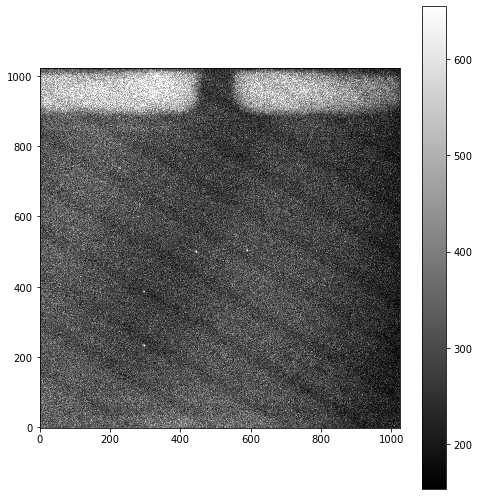

In [117]:
image = ccdp.CCDData.read(f)
show_image(image)